# MS-AAI-501: Intro to AI
## Final Project:  Airline Flight Delay Analysis and Modeling
### File Name:  XGBoos Model.jpynb
### Date:  12/4/2023
### Author:  Ned Kost


In [139]:
# Load Libraries used in this notebook
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import category_encoders as ce


In [120]:
# Function to Calculate difference in Date timestamps
#   date = Flight Date (when the airplane took off)
#   time1 = First time to use for calculation (i.e. DepTime)
#   time2 = Second time to use for calculatin (i.e.WheelsOff)
def calculate_date_diff(date, time1, time2):
    s1 = str(int(time1))
    s2 = str(int(time2))
    if(len(s1) < 3):
        t1 = date + dt.timedelta(minutes=time1)
    if(len(s2) < 3):
        t2 = date + dt.timedelta(minutes=time2)
    if(len(s1) == 3):
        t1 = date + dt.timedelta(hours=int(s1[0]), minutes=int(s1[-2:]))
    if(len(s2) == 3):
        t2 = date + dt.timedelta(hours=int(s2[0]), minutes=int(s2[-2:]))
    if(len(s1) > 3):
        t1 = date + dt.timedelta(hours=int(s1[:2]), minutes=int(s1[-2:]))
    if(len(s2) > 3):
        t2 = date + dt.timedelta(hours=int(s2[:2]), minutes=int(s2[-2:]))
    return (t2 - t1).total_seconds()

# Reducing dimensionality of TimeZones 
def binary_encode_timezone(df, columns):
    encoder = ce.BinaryEncoder(cols=columns)

    # Fit and transform to produce binary encoded data
    df_encoded = encoder.fit_transform(df[columns])

    # Merge the encoded data back with the original DataFrame
    df = df.drop(columns, axis=1)
    df = pd.concat([df, df_encoded], axis=1)
    return df

def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

def calculate_crsDeptTime(dept, delay):
    s = str(int(dept))
    if(len(s) < 3):
        t =  dt.timedelta(hours=0, minutes=int(dept))
    if(len(s) == 3):
        t =  dt.timedelta(hours=int(s[0]), minutes=int(s[-2:]))
    if(len(s) > 3):
        t =  dt.timedelta(hours=int(s[:2]), minutes=int(s[-2:]))
    delta = (t - dt.timedelta(minutes=int(delay)))
    result = days_hours_minutes(delta)
    return(float(str(result[1]) + (str(result[2]))))


# Data Loading and Preprocessing

In [121]:
# Load Flight and Weather Dataset
flights_df = pd.read_csv('../data/flight_data_weather.csv')

# Convert Flight Date to a Date Timestamp
flights_df['FlightDateDT'] = pd.to_datetime(flights_df['FlightDate'])

# Calculate the delta of Wheels Off - DepTime
flights_df['DepTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['DepTime'], x['WheelsOff']), axis=1)

# Calculate the delta of DepTime and Wheels Off
flights_df['ArrTarmacTime'] = flights_df.apply(lambda x: calculate_date_diff(x['FlightDateDT'], x['WheelsOn'], x['ArrTime']), axis=1)

# Reducing dimensionality of Carrier with custom grouping
value_counts = flights_df['Carrier'].value_counts()
to_remove = value_counts[value_counts <= 9000].index
flights_df['Carrier'].replace(to_remove, 'Other', inplace=True)

#  4) Calculate Employees Per Monthly Flight Count (Grand Total / Monthly Flights)
## Group flight dataset by Tail_Number
flightCount_df = pd.DataFrame(flights_df.groupby(['Carrier', 'Year', 'Month'])['Carrier'].count())
flightCount_df.rename(columns={'Carrier': 'MonthlyFlights'}, inplace=True)
flightCount_df = flightCount_df.reset_index()

# 5) Calculate CRSDepTime as Actual Departure Time minus Departure Delay
flights_df['CRSDepTime'] = flights_df.apply(lambda x: calculate_crsDeptTime(x['DepTime'], x['DepDelay']), axis=1)

## Merge Monthly flight count and calculate EmpPerMF
flights_df = pd.merge(flights_df, flightCount_df, how='left', left_on=['Carrier', 'Year', 'Month'], right_on=['Carrier', 'Year', 'Month'])
flights_df['EmpPerMF'] = flights_df['Grand Total'] / flights_df['MonthlyFlights']

# Rename ArrDel15 to Delayed - This is the column being predicted
flights_df.rename(columns={'ArrDel15':'Delayed'}, inplace=True)

flights_df.head()

Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate  \
0  2020.0      1.0    1.0         1.0        3.0  2020-01-01   
1  2020.0      1.0    1.0         1.0        3.0  2020-01-01   
2  2020.0      1.0    1.0         1.0        3.0  2020-01-01   
3  2020.0      1.0    1.0         1.0        3.0  2020-01-01   
4  2020.0      1.0    1.0         1.0        3.0  2020-01-01   

  Reporting_Airline Tail_Number  Flight_Number_Reporting_Airline Origin  ...  \
0                AA      N407AN                            664.0    KOA  ...   
1                9E      N297PQ                           5270.0    LFT  ...   
2                WN      N963WN                           1395.0    CMH  ...   
3                AA      N891NN                            137.0    TUS  ...   
4                AA      N807AW                           2189.0    SAT  ...   

  Dest_Precip  dest_ianaTimeZone  origin_ianaTimeZone  \
0         0.0    America/Phoenix  America/Los_Angeles   
1         0.0   America/New_York      America/Chicago   
2         0.0    America/Chicago     America/New_York   
3         0.0    America/Chicago      America/Phoenix   
4         0.0    America/Chicago      America/Chicago   

   Aircraft_Daily_Flight_Count  FlightDateDT  DepTarmacTime  ArrTarmacTime  \
0                            1    2020-01-01          900.0          360.0   
1                            1    2020-01-01          900.0          420.0   
2                            1    2020-01-01          540.0          300.0   
3                            1    2020-01-01         1200.0          840.0   
4                            1    2020-01-01          660.0          960.0   

   CRSDepTime  MonthlyFlights   EmpPerMF  
0      2355.0            1245  86.306827  
1        60.0             337  14.373887  
2       555.0            1542  40.347601  
3        60.0            1245  86.306827  
4       610.0            1245  86.306827  

[5 rows x 42 columns]

In [122]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343120 entries, 0 to 343119
Data columns (total 42 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Year                             343120 non-null  float64       
 1   Quarter                          343120 non-null  float64       
 2   Month                            343120 non-null  float64       
 3   DayofMonth                       343120 non-null  float64       
 4   DayOfWeek                        343120 non-null  float64       
 5   FlightDate                       343120 non-null  object        
 6   Reporting_Airline                343120 non-null  object        
 7   Tail_Number                      343120 non-null  object        
 8   Flight_Number_Reporting_Airline  343120 non-null  float64       
 9   Origin                           343120 non-null  object        
 10  Dest                             343120 non-

# XGBoost with Feature sets 1, 2, & 3

In [141]:
# Columns to use as Features
features = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone',
            'DepDelay','DepTarmacTime', 'AirTime', 'ArrTarmacTime']

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Encoding categorical variables
x = binary_encode_timezone(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
x = pd.get_dummies(x, columns=['Carrier'])


# Create a Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    

# Initialize XGBClassifier, and train it with training datasets
gb_model = XGBClassifier(n_estimators=800, learning_rate=0.1, random_state=42)
gb_model.fit(x_train,y_train)

# Predict Values and Probabilities from the test data
gb_predict = gb_model.predict(x_test)
gb_prob = gb_model.predict_proba(x_test)

# Calculate Accuracy scores (AUC, F1, Log Loss) of model
auc = roc_auc_score(y_test, gb_prob[:,1])
f1 = f1_score(y_test, gb_predict)
loss = log_loss(y_test, gb_predict)

# Print Metrics and Summary
print('(AUC) XGBoost Prob: %.4f' % auc)
print('F1 Score: %.4f' % f1)
print('Log Loss: %.4f' % loss)
print('')
print('Using Feature Set 1, 2, and 3 this model can get an AUC score of 99.95% which is extremely good!')
print('However, since this model uses information about Arrival, it may not be useful for a business case.')

(AUC) XGBoost Prob: 0.9994
F1 Score: 0.9887
Log Loss: 0.4122

Using Feature Set 1, 2, and 3 this model can get an AUC score of 99.95% which is extremely good!
However, since this model uses information about Arrival, it may not be useful for a business case.


# XGBoost with Feature Sets 1 & 2

In [135]:
# Columns to use as Features
features = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'Carrier', 'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time', 'Origin_Windspeed',
            'Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone',
            'DepDelay','DepTarmacTime']

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Encoding categorical variables
x = binary_encode_timezone(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
x = pd.get_dummies(x, columns=['Carrier'])

# Create a Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    

# Initialize XGBClassifier, and train it with training datasets
gb_model = XGBClassifier(n_estimators=800, learning_rate=0.1,random_state=42)
gb_model.fit(x_train,y_train)

# Predict Values and Probabilities from the test data
gb_predict = gb_model.predict(x_test)
gb_prob = gb_model.predict_proba(x_test)

# Calculate Accuracy scores (AUC, F1, Log Loss) of model
auc = roc_auc_score(y_test, gb_prob[:,1])
f1 = f1_score(y_test, gb_predict)
loss = log_loss(y_test, gb_predict)

# Print Metrics and Summary
print('(AUC) XGBoost Prob: %.4f' % auc)
print('F1 Score: %.4f' % f1)
print('Log Loss: %.4f' % loss)
print('')
print('With a reduced feature set that excludes Arrival information, we are able to get an AUC score of 96.83%.')
print('This is still a good score, and could be useful for determining the likilhood that a flight will be delayed up to the point of departure.')


(AUC) XGBoost Prob: 0.9683
F1 Score: 0.9118
Log Loss: 3.0913

With a reduced feature set that excludes Arrival information, we are able to get an AUC score of 96.83%.
This is still a good score, and could be useful for determining the likilhood that a flight will be delayed up to the point of departure.


# XGBoost With Feature Set 1 only

In [142]:
features = ['Month', 'DayOfWeek', 'DayofMonth', 'Origin', 'Dest','CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 'Distance', 'Carrier', 
            'Aircraft_Daily_Flight_Count', 'Full-time', 'Part-time',
            'Origin_Windspeed','Origin_Precip', 'Dest_Windspeed', 'Dest_Precip', 'origin_ianaTimeZone', 'dest_ianaTimeZone']
# Features = ['Year', 'Quarter', 'DayofMonth', 'Full-time', 'Part-time', 'Grand Total',  ]

# Declare X and Y from dataframe
x = flights_df[features]
y = flights_df['Delayed']

# Encoding categorical variables
x = binary_encode_timezone(x, ['origin_ianaTimeZone', 'dest_ianaTimeZone', 'Dest', 'Origin'])
x = pd.get_dummies(x, columns=['Carrier'])

# Create a Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    

# Initialize XGBClassifier, and train it with training datasets
gb_model = XGBClassifier(n_estimators=800, learning_rate=0.1,random_state=42, objective='binary:logistic')
gb_model.fit(x_train,y_train)

# Predict Values and Probabilities from the test data
gb_predict = gb_model.predict(x_test)
gb_prob = gb_model.predict_proba(x_test)

# Calculate Accuracy scores (AUC, F1, Log Loss) of model
auc = roc_auc_score(y_test, gb_prob[:,1])
f1 = f1_score(y_test, gb_predict)
loss = log_loss(y_test, gb_predict)

# Print Metrics and Summary
print('(AUC) XGBoost Prob: %.4f' % auc)
print('F1 Score: %.4f' % f1)
print('Log Loss: %.4f' % loss)
print('')
print('Removing the Feature Set 2 data, we get an AUC score of 69.17%.  This is not a great score, and is unlikely to be very useful.')
print('It may be helpful for determining potential probabilities that the flight could be delayed using the probabilities output from the model, though it will take some domain knowledge to make a definitive decision.')


(AUC) XGBoost Prob: 0.6919
F1 Score: 0.6318
Log Loss: 13.0237

Removing the Feature Set 2 data, we get an AUC score of 69.17%.  This is not a great score, and is unlikely to be very useful.
It may be helpful for determining potential probabilities that the flight could be delayed using the probabilities output from the model, though it will take some domain knowledge to make a definitive decision.


# Parameter Tuning

The below HyperParameter tuning using StratifiedKFold and GridSearch was performed with the Initial Logisitc Regression Model using Featue Sets 1, 2, and 3.  Once ideal parameters were identified, all models were updated with the same parameters.

Best: -0.637375 using {'learning_rate': 0.2, 'n_estimators': 200}
-0.692742 (0.000017) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.692344 (0.000034) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.689424 (0.000147) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.686289 (0.000259) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.670683 (0.000674) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.662612 (0.000966) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.645503 (0.001461) with: {'learning_rate': 0.1, 'n_estimators': 100}
-0.639900 (0.001598) with: {'learning_rate': 0.1, 'n_estimators': 200}
-0.640621 (0.001429) with: {'learning_rate': 0.2, 'n_estimators': 100}
-0.637375 (0.001491) with: {'learning_rate': 0.2, 'n_estimators': 200}
-0.639527 (0.001667) with: {'learning_rate': 0.3, 'n_estimators': 100}
-0.638880 (0.001816) with: {'learning_rate': 0.3, 'n_estimators': 200}


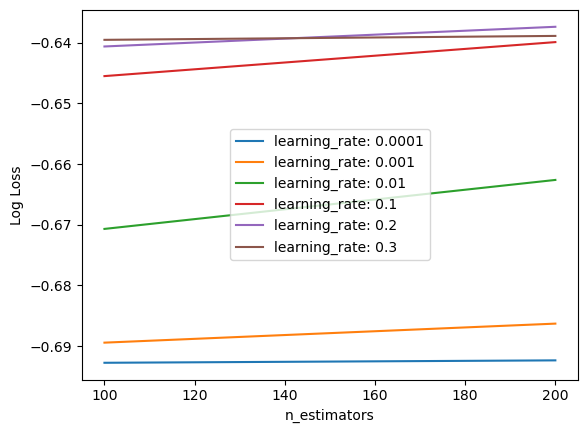

In [138]:
# Tune Nodes and Learning Rate to find best combination
n_estimators = [100, 200]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators)
tune_model = XGBClassifier()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(tune_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

Based on the above chart, the learning rates that look most promising are .1 and .2.  Each of these have an upward trajectory with the lowest log loss.

Best: -0.634748 using {'learning_rate': 0.1, 'n_estimators': 800}
-0.634819 (0.001925) with: {'learning_rate': 0.1, 'n_estimators': 600}
-0.634777 (0.002000) with: {'learning_rate': 0.1, 'n_estimators': 700}
-0.634748 (0.002042) with: {'learning_rate': 0.1, 'n_estimators': 800}
-0.634886 (0.002063) with: {'learning_rate': 0.1, 'n_estimators': 900}
-0.635045 (0.002086) with: {'learning_rate': 0.1, 'n_estimators': 1000}
-0.638520 (0.002033) with: {'learning_rate': 0.2, 'n_estimators': 600}
-0.639708 (0.002076) with: {'learning_rate': 0.2, 'n_estimators': 700}
-0.640774 (0.002265) with: {'learning_rate': 0.2, 'n_estimators': 800}
-0.642156 (0.002614) with: {'learning_rate': 0.2, 'n_estimators': 900}
-0.643527 (0.002917) with: {'learning_rate': 0.2, 'n_estimators': 1000}


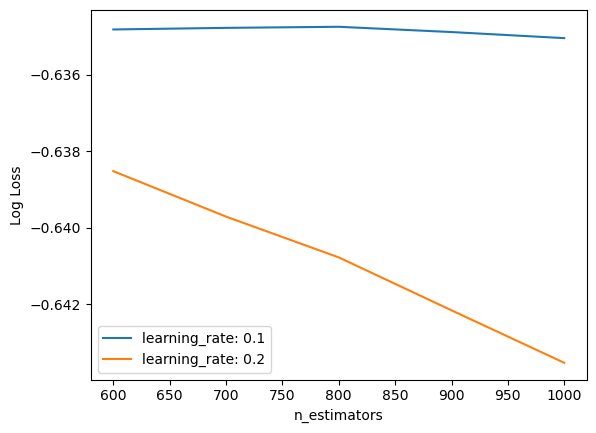

In [140]:
# Fine tune Learning Rate and Nodes for best combination
n_estimators = [600, 700, 800, 900, 1000]
learning_rate = [0.1, 0.2]

param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators)
tune_model = XGBClassifier()

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(tune_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

# Summarize Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

# Model Post Tuning

In [32]:
# Create a Test Train split of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)    

# Initialize XGBClassifier, and train it with training datasets
gb_model = XGBClassifier(n_estimators=800, learning_rate=0.1, random_state=42)
gb_model.fit(x_train,y_train)

# Predict model output
gb_predict = gb_model.predict(x_test)

#calculate AUC of model
auc = roc_auc_score(y_test, gb_predict)
f1 = f1_score(y_test, gb_predict)

#print AUC score
print('(AUC) XGBoost: %.4f' % auc)
print('F1 Score: %.4f' % f1)

(AUC) XGBoost: 0.9381
F1 Score: 0.9375
